In [376]:
# import libraries and files
import numpy as np
import camera_calibration as cc
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import copy

# For movies
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [338]:
# Set level
input_path = '../input_videos/'
output_path = '../output_videos/'
level = 0   # easy
level = 1 # medium
# level = 2 # hard

## Step One - Calibrate the camera

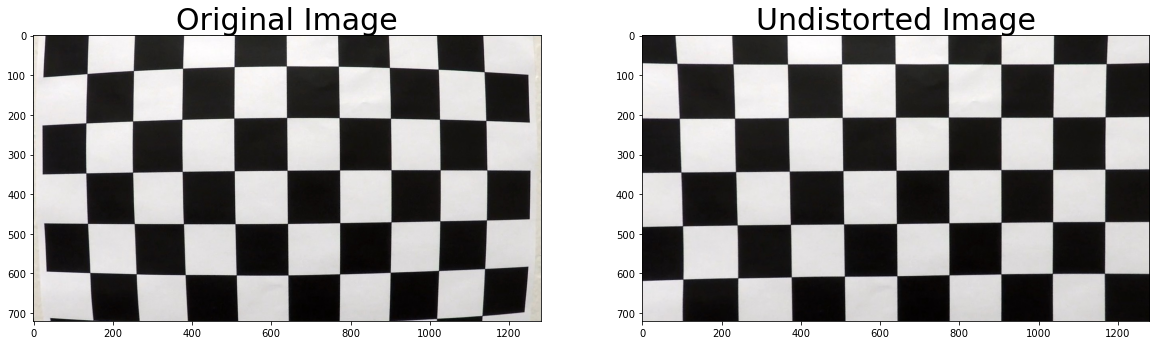

In [242]:
camera = cc.Camera()
mtx, dist = camera.calibrateCamera()
camera.testUndistortion()

# Step Two - Read the input movie

In [339]:
def setInputPath(lev, in_path):
    if lev == 0:
        in_path += 'easy.mp4'
    elif lev == 1:
        in_path += 'medium.mp4'
    elif lev == 2:
        in_path += 'hard.mp4'
    return in_path

def setOutputPath(lev, out_path):
    if lev == 0:
        out_path += 'easy.mp4'
    elif lev == 1:
        out_path += 'medium.mp4'
    elif lev == 2:
        out_path += 'hard.mp4'
    return out_path

movie_path = setInputPath(level, input_path)
movie_output_path = setOutputPath(level, output_path)
test_images_path = '../test_images/test3.jpg'

# APPRACH ONE - ON THE IMAGE

### 1. Load the image

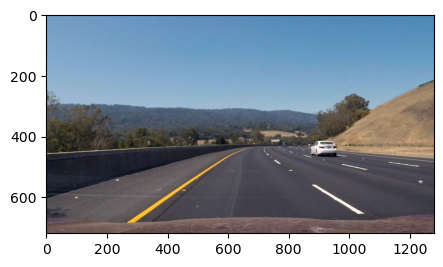

In [244]:
image = image = mpimg.imread(test_images_path)
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(image)

### 2. Undistort an image

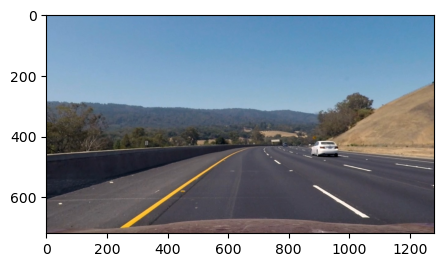

In [245]:
undistorted_image = camera.undistortImage(image)
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(undistorted_image)

### 3. Create thresholded binary image

In [343]:
s_channel_threshold = (170, 255)
sobel_threshold = (20, 100)
sobel_kernel = 11
directional_threshold = (0.7, 1.3)

In [344]:
def getBinaryImage(image):
    # Convert to HLS color space and separate the L and S channels
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Absolute Sobel over X and Y axis
    sobel_x = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in y
    sobel_y = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y

    abs_sobel_x = np.absolute(sobel_x) # Absolute x derivative to accentuate lines away from horizontal
    abs_sobel_y = np.absolute(sobel_y) # Absolute y derivative to accentuate lines away from horizontal

    directional_gradient = np.arctan2(abs_sobel_y, abs_sobel_x)
    directional_sobel_xy_binary = np.zeros_like(directional_gradient)
    directional_sobel_xy_binary[
        (directional_gradient >= directional_threshold[0]) & 
        (directional_gradient <= directional_threshold[1])] = 1


    scaled_sobel_y = np.uint8( 255 * abs_sobel_y / np.max(abs_sobel_y) )
    
    # Threshold y gradient
    sy_binary = np.zeros_like(scaled_sobel_y)
    sy_binary[
        (scaled_sobel_y >= sobel_threshold[0]) & 
        (scaled_sobel_y <= sobel_threshold[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[
        (s_channel >= s_channel_threshold[0]) & 
        (s_channel <= s_channel_threshold[1])] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sy_binary)
    combined_binary[((s_binary == 1) | (sy_binary == 1)) & (directional_sobel_xy_binary == 1)] = 1
    return combined_binary

### 4. Perform perspective transorm

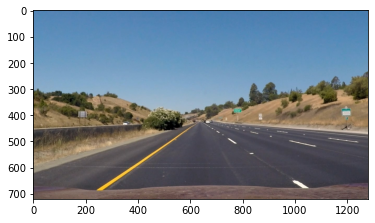

In [510]:
# base image
%matplotlib inline
path_img_straight_lines = '../test_images/straight_lines1.jpg'
img_str_lines = mpimg.imread(path_img_straight_lines)
undistored_str_lines = camera.undistortImage(img_str_lines)
plt.imshow(img_str_lines)

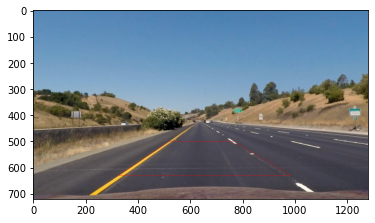

In [511]:
# Source coordinates
# %matplotlib qt
top_left = [520, 500]
bottom_left = [328, 630]
bottom_right = [985, 630]
top_right = [766, 500]

src = np.float32(
    [top_right,
    bottom_right,
    bottom_left,
    top_left])

# Destination coordinates
d_top_left = [320, 0]
d_bottom_left = [320, 720]
d_bottom_right = [960, 720]
d_top_right = [960, 0]

dst = np.float32(
    [
        d_top_right,
        d_bottom_right,
        d_bottom_left,
        d_top_left])

pol = np.array(
    [
        top_right,
        bottom_right,
        bottom_left,
        top_left], 
    np.int32)

color = (255, 0, 0)
thic = 1

copy_img = copy.copy(undistored_str_lines) 
image = cv2.polylines(copy_img, [pol], True, color, thic)

plt.imshow(image)

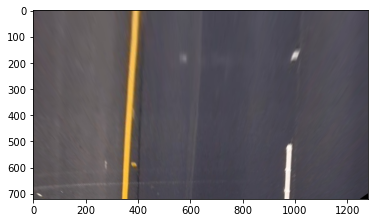

In [514]:
M = cv2.getPerspectiveTransform(src, dst)
img_size = (image.shape[1], image.shape[0])
warped = cv2.warpPerspective(undistorted_image, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped)

In [535]:
img_size = (undistorted_image.shape[0], undistorted_image.shape[1])
M = cv2.getPerspectiveTransform(src, dst)
def perspectiveTransform(bin_image):
    img_size = (bin_image.shape[1], bin_image.shape[0])
    warped = cv2.warpPerspective(bin_image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

### 5. Calculate the curve

In [ ]:
def findLaneCurve(bird_eye_img):
    return bird_eye_img

In [536]:
def processImage(image):
    img = copy.deepcopy(image)
    # plt.imshow(img)
    binary_image = getBinaryImage(image)
    birds_eye_image = perspectiveTransform(binary_image)
    # plt.imshow(birds_eye_image)
    # lookup = cv2.cvtColor(birds_eye_image, cv2.COLOR_GRAY2BGR) * 255
    return birds_eye_image

In [537]:
%matplotlib qt
out = processImage(undistorted_image)
plt.imshow(out, cmap='gray')

In [391]:
src

array([[ 305.,  740.],
       [ 110., 1280.],
       [ 660., 1280.],
       [ 415.,  740.]], dtype=float32)

In [341]:
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(movie_path).subclip(0,5)
modified_movie = clip1.fl_image(processImage) 
%time modified_movie.write_videofile(movie_output_path, audio=False)

t:   0%|          | 0/450 [00:00<?, ?it/s, now=None]Moviepy - Building video ../output_videos/medium.mp4.
Moviepy - Writing video ../output_videos/medium.mp4

Moviepy - Done !
Moviepy - video ready ../output_videos/medium.mp4
Wall time: 1min 27s


In [298]:
def process_image(image):
    # STEP ONE - UNDISTORT AN IMAGE
    undistorted = camera.undistortImage(image)
    # gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
    # hls_selection_image = hls_selection(undistorted, (130, 250))
    thr_magnit_img = thresholds_magnitude_selection(undistorted, sobel_kernel_size, magnitude_thresholds)
    thr_dir_img = thresholds_direction_selection(undistorted, sobel_kernel_size, direction_thresholds)
    grad_x = abs_sobel_threshold(undistorted, 'x', sobel_kernel_size, magnitude_thresholds)
    grad_y = abs_sobel_threshold(undistorted, 'y', sobel_kernel_size, magnitude_thresholds)

    combined = np.zeros_like(thr_magnit_img) 
    # combined[(((thr_dir_img == 1) & (thr_magnit_img == 1)) | (hls_selection_image == 1)) ] = 1
    # combined[((thr_dir_img == 1) & (thr_magnit_img == 1))] = 1
    combined[((grad_x == 1) & (grad_y == 1)) | ((thr_magnit_img == 1) & (thr_dir_img == 1))] = 1

    lookup = cv2.cvtColor(combined, cv2.COLOR_GRAY2BGR) * 255
    return lookup

    # gray_image = grayscale(image)
    # blur_image = gaussian_blur(gray_image, kernel_size)
    # # roi_image = region_of_interest(blur_image, vertices)
    # edges_image = canny(blur_image, low_threshold, high_threshold)
    # roi_image = region_of_interest(edges_image, vertices)
    
    # lines_image = hough_lines(roi_image, rho, theta, threshold, min_line_length, max_line_gap)
   
    # joined_image = weighted_img(lines_image, image)
    # joined_image = cv2.cvtColor(hls_selection_image, cv2.COLOR_RGB2BGR)
    return thr_magnit_img

t:   2%|▏         | 2/125 [00:00<00:10, 12.27it/s, now=None]Moviepy - Building video ../output_videos/easy.mp4.
Moviepy - Writing video ../output_videos/easy.mp4

Moviepy - Done !
Moviepy - video ready ../output_videos/easy.mp4
Wall time: 11.2 s
